In [66]:
import numpy as np
import mne

In [67]:
# https://raphaelvallat.com/bandpower.html

In [68]:
# Decompose the signal into distinct frequency bands: [delta, theta, alpha, beta]
# PSD: signal -> FFT -> |val|^2 -> Power Spectral Density (periodogram) uV^2/Hz
# Average Band Power: contribution of given frequency band to overall power of the signal

In [69]:
# Compute the Power Spetral Density (PSD)
# - welch's periodogram, FFT of small windows of signal w | w/o overlap (freq_res = 1/t)
# - MultiTaper method: 
#   + https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5343535/
#   + https://www.physiology.org/doi/full/10.1152/physiol.00062.2015
#   + https://www.physiology.org/doi/pdf/10.1152/physiol.00062.2015
# Then Compute Average Band Power for each Band (Delta, Theta.. etc)
# - Relative Power (compared to entire signal)
# - Absolute Power(just power uV^2)

In [70]:
data = np.loadtxt('../data/example-eeg/data.txt')

In [71]:
# Taking a look at the data
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
sns.set(font_scale=1.2)

In [73]:
sf=100. # Sampling frequency & timevector
time = np.arange(data.size) / sf

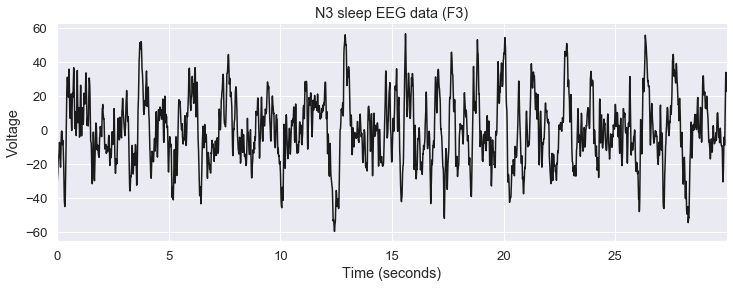

In [74]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()

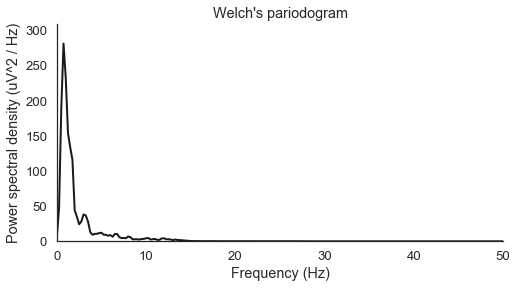

In [75]:
from scipy import signal
win = 4 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8,4))
plt.plot(freqs, psd, color='k', lw=2)
plt.ylim([0, psd.max() * 1.1])
plt.xlim([0, freqs.max()])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.title("Welch's pariodogram")
sns.despine()

In [76]:
low, high = 0.5, 4
idx_delta = np.logical_and(freqs >= low, freqs <= high)

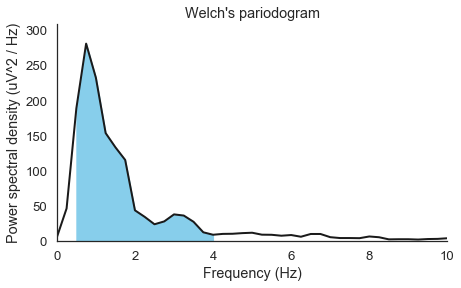

In [77]:
plt.figure(figsize=(7,4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.title("Welch's pariodogram")
sns.despine()

In [78]:
from scipy.integrate import simps

freq_res = freqs[1] - freqs[0]

delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 321.064 uV^2


In [79]:
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f uV^2' % delta_rel_power)

Relative delta power: 0.787 uV^2


In [80]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [81]:
win_sec = 4
delta = [0.5, 4]
beta = [12, 30]
db = bandpower(data, sf, delta, win_sec) / bandpower(data, sf, beta, win_sec)
db_rel = bandpower(data, sf, delta, win_sec, True) / bandpower(data, sf, beta, win_sec, True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 42.214
Delta/beta ratio (relative): 42.214


In [82]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [83]:
# Multitaper delta power
bp = bandpower(data, sf, [0.5, 4], 'multitaper')
bp_rel = bandpower(data, sf, [0.5, 4], 'multitaper', relative=True)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel)

# Delta-beta ratio
# One advantage of the multitaper is that we don't need to define a window length.
db = bandpower(data, sf, [0.5, 4], 'multitaper') / bandpower(data, sf, [12, 30], 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], 'multitaper', relative=True) / \
                    bandpower(data, sf, [12, 30], 'multitaper', relative=True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Absolute delta power: 311.559
Relative delta power: 0.790
Delta/beta ratio (absolute): 41.225
Delta/beta ratio (relative): 41.225


/opt/anaconda3/envs/cse6250-project-sleep/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/opt/anaconda3/envs/cse6250-project-sleep/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/opt/anaconda3/envs/cse6250-project-sleep/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individu

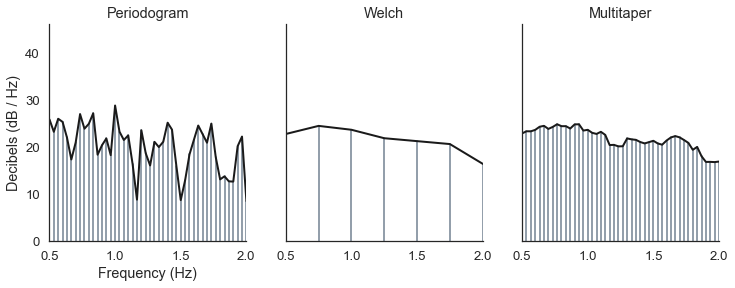

In [84]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax1.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax2.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax1.plot(freqs, psd, lw=lw, color=lc)
    ax2.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax1.set_title('Periodogram')
    ax2.set_title('Welch')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()

# Example: plot the 0.5 - 2 Hz band
plot_spectrum_methods(data, sf, 4, [0.5, 2], dB=True)

In [85]:
%timeit bandpower(data, sf, [0.5, 4], method="welch", relative=True)
%timeit bandpower(data, sf, [0.5, 4], method="multitaper", relative=True)

334 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12.9 ms ± 86.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
